In [1]:
#Importar las librerias necesarias 
import numpy as np 
import pandas as pd

In [2]:
#matplotlib y seaborn para visualización 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sqlite3

# Abrir el archivo CVS
BMW_df = pd.read_csv('BMW_sales_data__2010-2024_.csv')

# Crear conexión y guardar en SQLite
conn = sqlite3.connect('BMW_database.db')
BMW_df.to_sql('ventas_bmw', conn, if_exists='replace', index=False)

cursor = conn.cursor()  # Habilitar el tren


In [4]:
cursor.execute("""
ALTER TABLE ventas_bmw
ADD COLUMN Total_Sales INTEGER;
""")

cursor.execute("""
UPDATE ventas_bmw
SET Total_Sales = Sales_Volume * Price_USD;
""")

conn.commit()

In [5]:
# Leer la tabla nuevamente incluyendo la nueva columna 
BMW_df = pd.read_sql_query("SELECT * FROM ventas_bmw", conn)
print(BMW_df.head())

      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  Total_Sales  
0      151748      98740          8300                 High    819542000  
1      121671      79219          3428                  Low    271562732  
2       10991     113265          6994                  Low    792175410  
3       27255      60971          4047                  Low    246749637  
4      122131      49898          3080                  Low    153685840  


In [6]:
# CONSULTA 1: ¿ Cuál es el volumen total de ventas y volumen por región?

# Volumen Total
consulta1 = """
SELECT SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
"""

cursor.execute(consulta1)
resultado1 = cursor.fetchall()
print("Total Ventas en USD:")
print(int(resultado1[0][0]))
print("----------------------")

# Volumen por región
consulta1a = """ 
SELECT Region, SUM(Total_Sales) AS Sales_by_Region
FROM ventas_bmw
GROUP BY Region
ORDER BY Sales_by_Region DESC
"""

cursor.execute(consulta1a)
resultado1a = cursor.fetchall()

print("Región --- Total Ventas")
for region, ventas in resultado1a:
    print(f"{region} --- {ventas}")

Total Ventas en USD:
19012242534459
----------------------
Región --- Total Ventas
Asia --- 3250635961348
Europe --- 3188079573212
North America --- 3182938635076
Middle East --- 3167783530851
South America --- 3113805414620
Africa --- 3108999419352


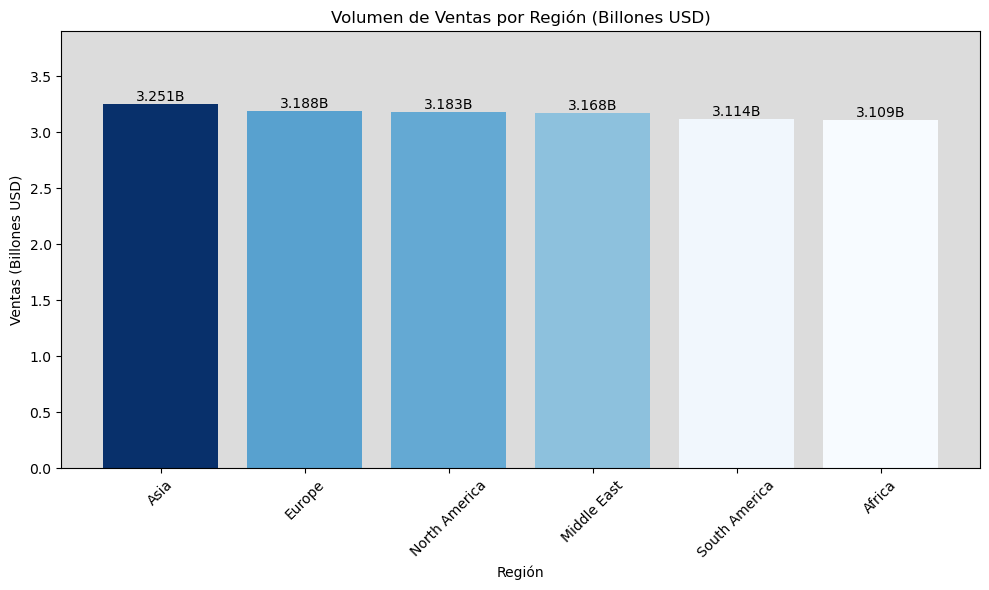

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir los resultados a DataFrame
df = pd.DataFrame(resultado1a, columns=['Region', 'Sales'])

# Escalar a Billones para mejor lectura
df['Sales'] = df['Sales'] / 1_000_000_000_000

# Crear un colormap basado en las ventas 
cmap = plt.cm.Blues
norm = plt.Normalize(df['Sales'].min(), df['Sales'].max())
colors = cmap(norm(df['Sales']))

# Crear la figura y los axes
fig, ax = plt.subplots(figsize=(10, 6))

# Color del fondo del plot
ax.set_facecolor('gainsboro') 

bars = ax.bar(df['Region'], df['Sales'], color=colors)

# Agregarle los valores encima de las barras
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}B",
        ha='center',
        va='bottom'
    )

# Expandir el espacio por encima de las barras 
ax.set_ylim(0, df['Sales'].max() * 1.2)  # 20% espacio extra

# Etiquetas y Título
ax.set_title("Volumen de Ventas por Región (Billones USD)")
ax.set_xlabel("Región")
ax.set_ylabel("Ventas (Billones USD)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
# CONSULTA 2: ¿Cuál es el mix de ventas por modelo y tipo de combustible?

consulta2 = """
SELECT Model, Fuel_Type,
       SUM(Sales_Volume) AS Total_Volume_Sales,
       SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
GROUP BY Model, Fuel_Type
ORDER BY Model DESC
"""
cursor.execute(consulta2)
resultado2 = cursor.fetchall()

print("Modelo -- Combustible -- Unidades Vendidas -- Total Ventas en USD")
for model, fuel_type, total_volume_sales, Total_Sales in resultado2:
    print(f"{model} -- {fuel_type} -- {total_volume_sales} -- {Total_Sales} ")

Modelo -- Combustible -- Unidades Vendidas -- Total Ventas en USD
i8 -- Diesel -- 5695989 -- 430680833205 
i8 -- Electric -- 5758878 -- 432685457985 
i8 -- Hybrid -- 6025969 -- 449909150592 
i8 -- Petrol -- 5943055 -- 451468006747 
i3 -- Diesel -- 5985791 -- 444527233216 
i3 -- Electric -- 5656625 -- 420742372527 
i3 -- Hybrid -- 5665338 -- 423815103486 
i3 -- Petrol -- 5826095 -- 435112820981 
X6 -- Diesel -- 5560446 -- 415960342388 
X6 -- Electric -- 5492824 -- 407333828846 
X6 -- Hybrid -- 5775905 -- 428566182774 
X6 -- Petrol -- 5832811 -- 441562900971 
X5 -- Diesel -- 5757666 -- 432430982580 
X5 -- Electric -- 5741201 -- 433234599344 
X5 -- Hybrid -- 5458184 -- 411136175914 
X5 -- Petrol -- 5752698 -- 431851625934 
X3 -- Diesel -- 5681507 -- 423415307381 
X3 -- Electric -- 5671004 -- 430569414802 
X3 -- Hybrid -- 5808364 -- 436157855089 
X3 -- Petrol -- 5584654 -- 417808611210 
X1 -- Diesel -- 5741748 -- 427715786403 
X1 -- Electric -- 6028920 -- 454394918510 
X1 -- Hybrid -- 5876

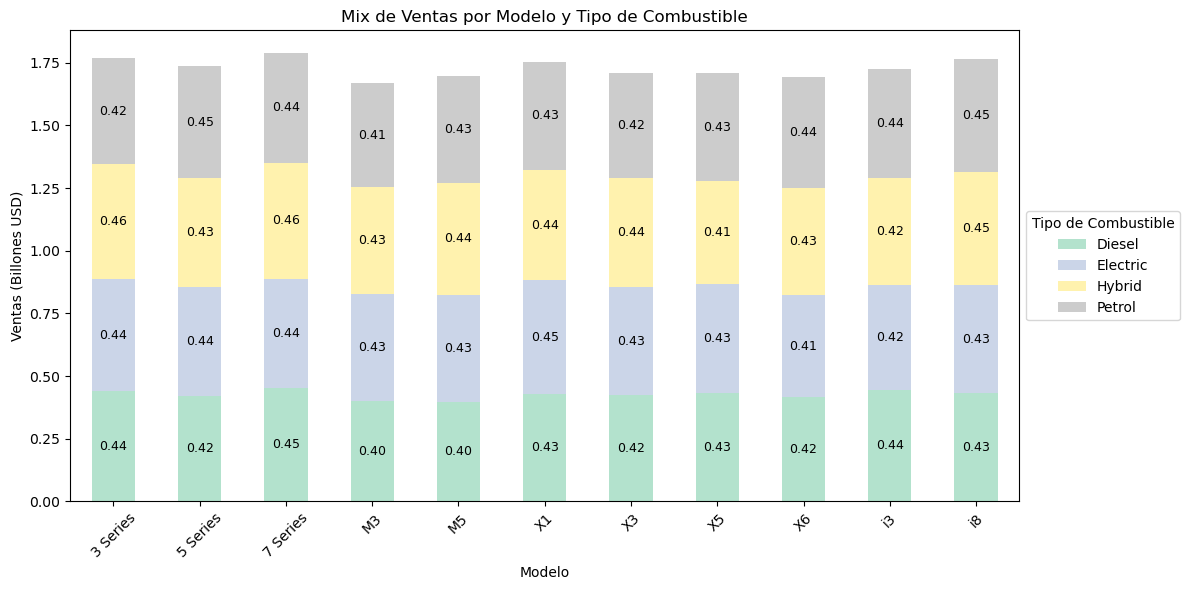

In [128]:
# Convertir los resultados a DataFrame
df2 = pd.DataFrame(resultado2, columns=['Model', 'Fuel_Type', 'Total_Volume_Sales', 'Total_Sales'])
# Escalar a Billones para mejor lectura
df2['Total_Sales_T'] = df2['Total_Sales'] / 1_000_000_000_000

# Pivot data para que cada combustible sea una columna
df_pivot = df2.pivot(index='Model', columns='Fuel_Type', values='Total_Sales_T').fillna(0)

# Plot barras apliadas
df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Pastel2'
)

# Agregar etiquetas par cada segmento
for i, model in enumerate(df_pivot.index):
    bottom = 0
    for fuel_type in df_pivot.columns:
        height = df_pivot.loc[model, fuel_type]
        if height > 0:
            plt.text(
                x=i,
                y=bottom + height / 2,
                s=f"{height:.2f}",
                ha='center',
                va='center',
                fontsize=9
            )
            bottom += height

# Situar el cuadro de leyendas fuera del plot
plt.legend(
    title='Tipo de Combustible',
    loc='center left',           
    bbox_to_anchor=(1, 0.5)      
)

plt.title("Mix de Ventas por Modelo y Tipo de Combustible")
plt.xlabel("Modelo")
plt.ylabel("Ventas (Billones USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
# CONSULTA 3: ¿ Cuál es la evolución anual de las ventas de cada modelo? Detección de modelos débiles y fuertes.

consulta3 = """
SELECT Model, Year, 
SUM(Sales_Volume) AS Total_Volume_Sales,
SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
GROUP BY Model, Year
ORDER BY Model, Year ASC; 
"""

cursor.execute(consulta3)
resultado3 = cursor.fetchall()

print("Modelo - Año - Unidades Vendidas - Total Ventas en USD")
for modelo, ventas, unidades_vendidas, total_ventas in resultado3:
    print(f"{modelo} -- {ventas} -- {unidades_vendidas} -- {total_ventas}")


Modelo - Año - Unidades Vendidas - Total Ventas en USD
3 Series -- 2010 -- 1647769 -- 123206927162
3 Series -- 2011 -- 1473102 -- 112158137942
3 Series -- 2012 -- 1378152 -- 104983651057
3 Series -- 2013 -- 1448530 -- 110027948071
3 Series -- 2014 -- 1682545 -- 126664028300
3 Series -- 2015 -- 1620499 -- 123642903728
3 Series -- 2016 -- 1712098 -- 129698953207
3 Series -- 2017 -- 1497382 -- 112375019878
3 Series -- 2018 -- 1620038 -- 121807552107
3 Series -- 2019 -- 1459935 -- 111734464764
3 Series -- 2020 -- 1537651 -- 121590272086
3 Series -- 2021 -- 1579384 -- 122249226604
3 Series -- 2022 -- 1601902 -- 119685223915
3 Series -- 2023 -- 1510756 -- 113188690600
3 Series -- 2024 -- 1511560 -- 115521028793
5 Series -- 2010 -- 1501229 -- 106920016980
5 Series -- 2011 -- 1552268 -- 117534126070
5 Series -- 2012 -- 1536071 -- 114151647311
5 Series -- 2013 -- 1504123 -- 112719333498
5 Series -- 2014 -- 1491198 -- 109970720994
5 Series -- 2015 -- 1606539 -- 117899813503
5 Series -- 2016 -- 1

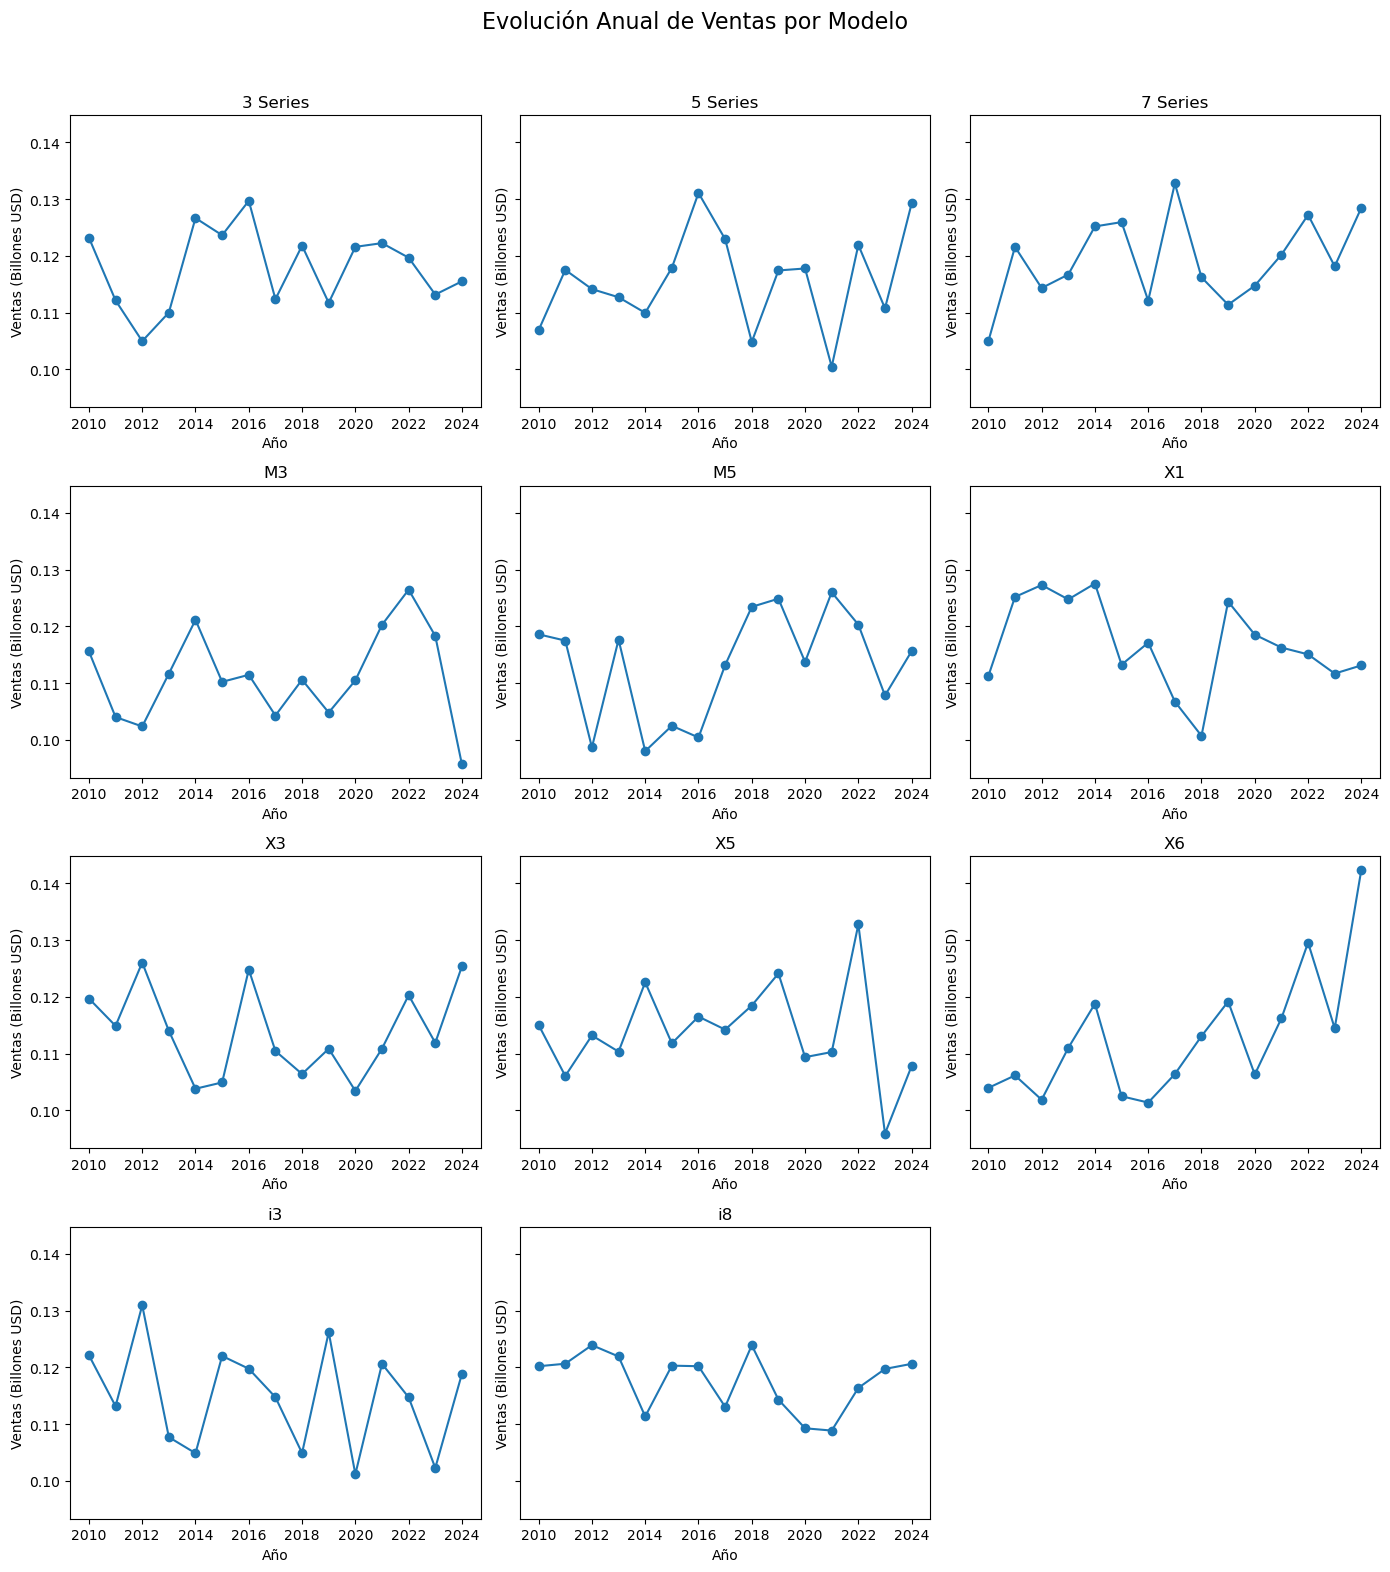

In [129]:
# Convertir los resultados a DataFrame
df3 = pd.DataFrame(resultado3, columns=['Model', 'Year', 'Total_Volume_Sales', 'Total_Sales'])
# Escalar a Billones para mejor lectura
df3['Total_Sales_T'] = df3['Total_Sales'] / 1_000_000_000_000

# Obtener lista de modelos unicos 
models = df3['Model'].unique()
n_models = len(models)

# Subplot grid tamaño
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), sharex=False, sharey=True)
axes = axes.flatten()  # flatten in case of multiple rows

# Plotear cada modelo en su propio gráfico
for i, model in enumerate(models):
    ax = axes[i]
    df_model = df3[df3['Model'] == model]
    ax.plot(df_model['Year'], df_model['Total_Sales_T'], marker='o')
    ax.set_title(model)
    ax.set_xlabel('Año')
    ax.set_ylabel('Ventas (Billones USD)')

# Esconder subplots que no se usan 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Evolución Anual de Ventas por Modelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # espacio para subtítulos 
fig.savefig("evolucion_ventas_modelos.png", dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# CONSULTA 4: ¿Cómo son las preferencias de colores por región?

consulta4 = """
SELECT Region, Color,
SUM(Sales_Volume) AS Total_Volume_Sales,
SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
GROUP BY Region, Color
ORDER BY Region, Total_Volume_Sales ASC; 
"""

cursor.execute(consulta4)
resultado4 = cursor.fetchall()

print("Región - Color - Unidades Vendidas - Total Ventas en USD")
for region, color, unidades_vendidas, total_ventas in resultado4:
    print(f"{region} -- {color} -- {unidades_vendidas} -- {total_ventas}")


Región - Color - Unidades Vendidas - Total Ventas en USD
Africa -- Black -- 6623881 -- 489360388567
Africa -- Blue -- 6884183 -- 521535217332
Africa -- Silver -- 6885841 -- 506325547343
Africa -- Red -- 6978435 -- 522594062229
Africa -- Grey -- 7095931 -- 531994092525
Africa -- White -- 7096981 -- 537190111356
Asia -- Silver -- 6949489 -- 522043991888
Asia -- White -- 6995728 -- 535349078164
Asia -- Blue -- 7099311 -- 537090699053
Asia -- Red -- 7191807 -- 543410288534
Asia -- Grey -- 7210612 -- 543427099176
Asia -- Black -- 7527330 -- 569314804533
Europe -- Red -- 6901077 -- 507685381552
Europe -- Grey -- 6902592 -- 517540121860
Europe -- Silver -- 7054779 -- 534929486725
Europe -- White -- 7064770 -- 532135888922
Europe -- Blue -- 7139262 -- 530593115011
Europe -- Black -- 7492658 -- 565195579142
Middle East -- Black -- 6725246 -- 508000512932
Middle East -- Blue -- 6917547 -- 527368900685
Middle East -- White -- 6949851 -- 527837621073
Middle East -- Red -- 7152329 -- 528297150594
M

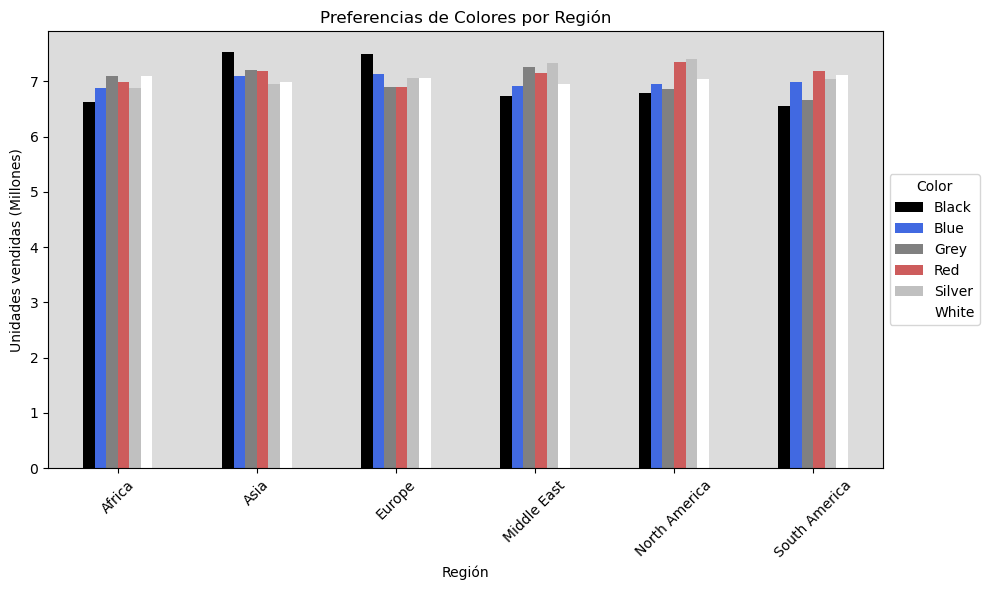

In [130]:
# Convertir los resultados a DataFrame
df4 = pd.DataFrame(resultado4, columns=['Region', 'Color', 'Total_Volume_Sales', 'Total_Sales'])
df4['Total_Volume_Sales_M'] = df4['Total_Volume_Sales'] / 1_000_000

df_pivot = df4.pivot(index='Region', columns='Color', values='Total_Volume_Sales_M').fillna(0)

# Mapping de nombre de colores a colores de matplotlib 
color_map = {
    'Black': 'black',
    'Blue': 'royalblue',
    'Red': 'indianred',
    'Gray': 'grey',
    'Silver': 'silver',
    'White': 'white',
}

# Listar los colores en el mismo orden que las columnas 
colors = [color_map.get(c, 'gray') for c in df_pivot.columns]

# Crear figura y axes
fig, ax = plt.subplots(figsize=(10, 6))

# Color del fondo 
ax.set_facecolor('gainsboro')


df_pivot.plot(
    kind='bar',
    color=colors,
    ax=ax
)

# Agregar etiquetas y formato 
plt.title("Preferencias de Colores por Región")
plt.xlabel("Región")
plt.ylabel("Unidades vendidas (Millones)")
plt.xticks(rotation=45)
plt.legend(title='Color', bbox_to_anchor=(1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

In [71]:
# CONSULTA 5: ¿Cuál es el modelo más vendido por región?

consulta5 = """
WITH RegionSales AS (
    SELECT 
        Region, 
        Model, 
        SUM(Sales_Volume) AS Total_Volume_Sales,
        SUM(Total_Sales) AS Total_Sales,        
        RANK() OVER (PARTITION BY Region ORDER BY SUM(Sales_Volume) DESC) as rnk
    FROM ventas_bmw
    GROUP BY Region, Model
)
SELECT Region, Model, Total_Volume_Sales, Total_Sales
FROM RegionSales
WHERE rnk = 1;
"""

# Ejecutar la consulta
cursor.execute(consulta5)
resultado5 = cursor.fetchall()

# Mostrar resultados
print("Región - Modelo más vendido - Unidades Vendidas -- Total Ventas en USD")
for region, model, total_volume_sales, Total_Sales in resultado5:
    print(f"{region} -- {model} -- {total_volume_sales} -- {Total_Sales}")

Región - Modelo más vendido - Unidades Vendidas -- Total Ventas en USD
Africa -- 5 Series -- 4020702 -- 306136833319
Asia -- X1 -- 4192289 -- 310980489459
Europe -- i8 -- 4202401 -- 322248193289
Middle East -- 7 Series -- 4080751 -- 308396604258
North America -- 7 Series -- 4087259 -- 314780958629
South America -- X6 -- 4023804 -- 296363783436


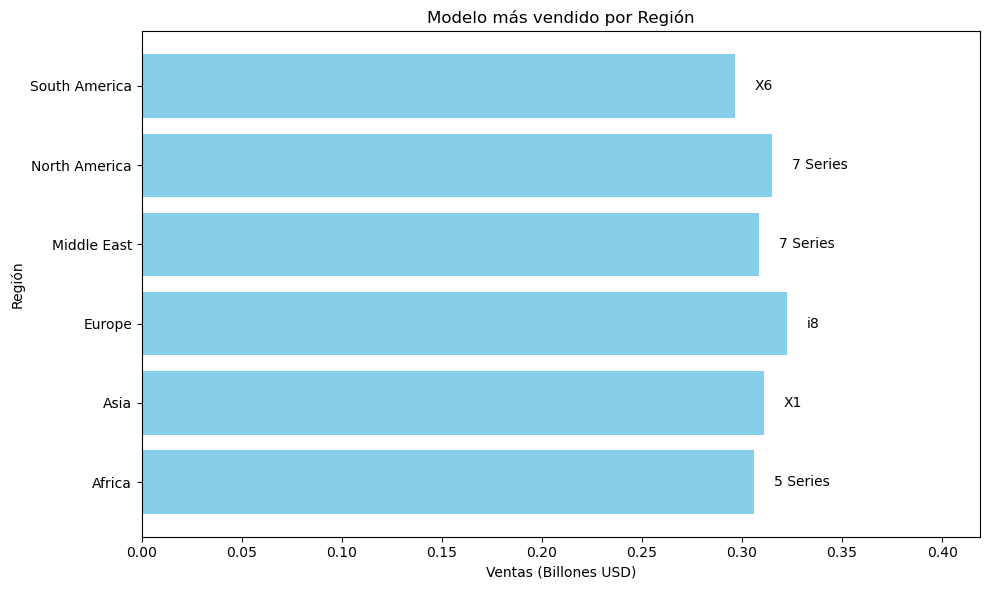

In [132]:
# Convertir los resultados a DataFrame
df5 = pd.DataFrame(resultado5, columns=['Region', 'Model', 'Total_Volume_Sales', 'Total_Sales'])
df5['Total_Sales_T'] = df5['Total_Sales'] / 1_000_000_000_000

# Plot barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(df5['Region'], df5['Total_Sales_T'], color='skyblue')

# Agregar etiqueta de valores y modelos en las barras 
for i, row in df5.iterrows():
    plt.text(
        x=row['Total_Sales_T'] + 0.01,          
        y=i,
        s=f"{row['Model']}",  
        va='center',
        ha='left',
        fontsize=10
    )

# Aumentar el espacio en el eje X 
plt.xlim(0, df5['Total_Sales_T'].max() * 1.3)

plt.title("Modelo más vendido por Región")
plt.xlabel("Ventas (Billones USD)")
plt.ylabel("Región")
plt.tight_layout()
plt.show()


In [80]:
# CONSULTA 6: ¿Cuál es la participación de cada modelo en el total de ventas?

consulta6 = """
SELECT Model,
       SUM(Total_Sales) AS Total_Sales,
       SUM(Total_Sales) * 100.0 / (SELECT SUM(Total_Sales) FROM ventas_bmw) AS Market_Share
FROM ventas_bmw
GROUP BY Model
ORDER BY Total_Sales DESC;
"""

cursor.execute(consulta6)
resultado6 = cursor.fetchall()

print("Modelo - Total Ventas en USD - Cuota de mercado")
for modelo, total_ventas, market_share in resultado6:
    print(f"{modelo} -- {total_ventas} -- {market_share}")


Modelo - Total Ventas en USD - Cuota de mercado
7 Series -- 1790070249282 -- 9.415355637492855
3 Series -- 1768534028214 -- 9.302080093963646
i8 -- 1764743448529 -- 9.282142521222662
X1 -- 1752985285361 -- 9.220297301508635
5 Series -- 1735712423092 -- 9.129446039551011
i3 -- 1724197530210 -- 9.068880365295964
X5 -- 1708653383772 -- 8.987121748921137
X3 -- 1707951188482 -- 8.983428364047011
M5 -- 1698467355916 -- 8.933545597462212
X6 -- 1693423254979 -- 8.907014792756467
M3 -- 1667504386622 -- 8.770687537778402


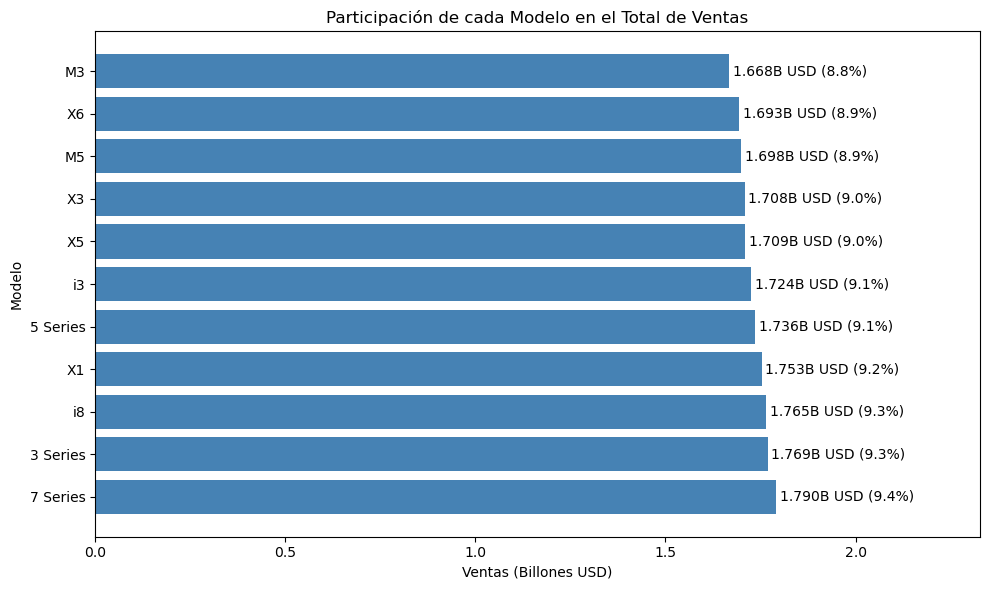

In [133]:
# Convertir los resultados a DataFrame
df6 = pd.DataFrame(resultado6, columns=['Model', 'Total_Sales', 'Market_Share'])

# Escalar a Billones para mejor lectura
df6['Total_Sales_T'] = df6['Total_Sales'] / 1_000_000_000_000

# Plot barras horizontales 
plt.figure(figsize=(10, 6))
bars = plt.barh(df6['Model'], df6['Total_Sales_T'], color='steelblue')

# Agregar etiquetas con las ventas y el porcentaje
for i, row in df6.iterrows():
    plt.text(
        x=row['Total_Sales_T'] + 0.01, 
        y=i,
        s=f"{row['Total_Sales_T']:.3f}B USD ({row['Market_Share']:.1f}%)",
        va='center',
        ha='left',
        fontsize=10
    )

# Expandir el eje X
plt.xlim(0, df6['Total_Sales_T'].max() * 1.3)

plt.title("Participación de cada Modelo en el Total de Ventas")
plt.xlabel("Ventas (Billones USD)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()


In [88]:
# CONSULTA 7: ¿Cuál es el Kilometraje promedio por tipo de combustible?

consulta7 = """
SELECT Fuel_Type,
       AVG(Mileage_KM) AS Avg_Mileage
FROM ventas_bmw
GROUP BY Fuel_Type
ORDER BY Avg_Mileage DESC;
"""
cursor.execute(consulta7)
resultado7 = cursor.fetchall()

print("Tipo de combustible - Kilometraje promedio")
for Fuel_Type, Avg_Mileage in resultado7:
    print(f"{Fuel_Type} -- {Avg_Mileage} ")


Tipo de combustible - Kilometraje promedio
Diesel -- 100905.52548316073 
Electric -- 100524.27447678614 
Hybrid -- 100063.7671437559 
Petrol -- 99753.51458167331 


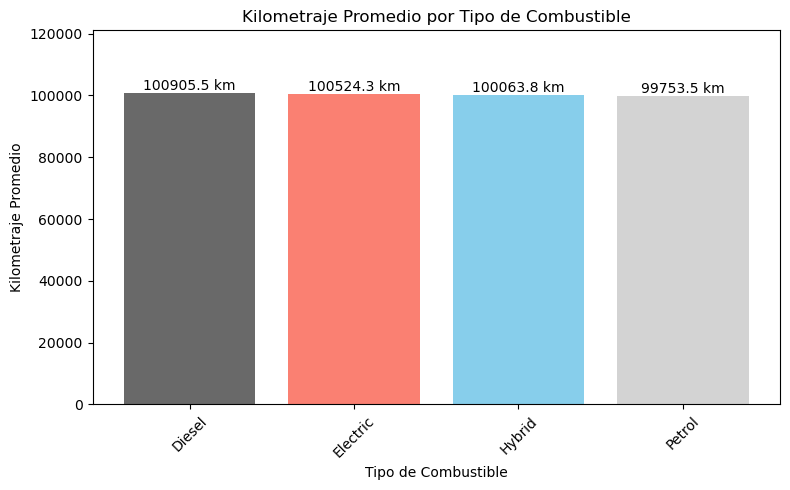

In [137]:
# Convertir los resultados a DataFrame
df7 = pd.DataFrame(resultado7, columns=['Fuel_Type', 'Avg_Mileage'])

# Definir los colores de las barras 
colors = ['dimgrey', 'salmon', 'skyblue', 'lightgrey'] 
colors = colors[:len(df7)] 

# Plot barras verticales
plt.figure(figsize=(8, 5))
bars = plt.bar(df7['Fuel_Type'], df7['Avg_Mileage'], color=colors)

# Agregar valores sobre las columnas
for i, row in df7.iterrows():
    plt.text(
        x=i,
        y=row['Avg_Mileage'] + 1,  # slightly above the bar
        s=f"{row['Avg_Mileage']:.1f} km",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Agregar espacio sobre las barras
plt.ylim(0, df7['Avg_Mileage'].max() * 1.2)

plt.title("Kilometraje Promedio por Tipo de Combustible")
plt.xlabel("Tipo de Combustible")
plt.ylabel("Kilometraje Promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
# CONSULTA 8: ¿Cuál es el total de ventas por tipo de transmisión?

consulta8 = """
SELECT Transmission,
       SUM(Sales_Volume) AS Total_Volume_Sales,
       SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
GROUP BY Transmission
ORDER BY Total_Sales ASC;
"""
cursor.execute(consulta8)
resultado8 = cursor.fetchall()

print("Tipo de Transmisión - Unidades Vendidad -  Total Ventas en USD")
for Transmission, Total_Volume_Sales, Total_Sales in resultado8:
    print(f"{Transmission} -- {Total_Volume_Sales} -- {Total_Sales} ")


Tipo de Transmisión - Unidades Vendidad -  Total Ventas en USD
Automatic -- 126013657 -- 9460579467414 
Manual -- 127362077 -- 9551663067045 


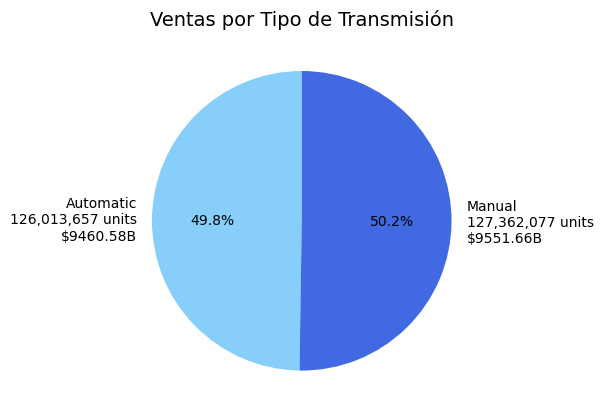

In [138]:
# Convertir los resultados a DataFrame
df8 = pd.DataFrame(resultado8, columns=['Transmission', 'Total_Volume_Sales', 'Total_Sales'])

# Preparar valores
labels = []
for i, row in df8.iterrows():
    transmission = row['Transmission']
    units = row['Total_Volume_Sales']
    usd = row['Total_Sales']
    
    usd_billions = usd / 1_000_000_000
    
    label = f"{transmission}\n{units:,} units\n${usd_billions:.2f}B"
    labels.append(label)

sizes = df8['Total_Sales']  

# Definir colores
colors = ['lightskyblue', 'royalblue']

plt.figure(figsize=(6, 6))

plt.pie(
    sizes,
    labels=labels,
    colors=colors[:len(labels)],
    startangle=90,
    autopct='%1.1f%%',
    textprops={'fontsize': 10}
)

plt.title("Ventas por Tipo de Transmisión", fontsize=14)

plt.tight_layout()
plt.show()

In [114]:
# CONSULTA 9: ¿Cómo ha evolucionado la venta de los modelos manuales y automáticos en el tiempo?

consulta9 = """
SELECT Transmission, Year, 
SUM(Sales_Volume) AS Total_Volume_Sales,
SUM(Total_Sales) AS Total_Sales
FROM ventas_bmw
GROUP BY Transmission, Year
ORDER BY Transmission, Year ASC; 
"""

cursor.execute(consulta9)
resultado9 = cursor.fetchall()

print("Transmisión - Año - Unidades Vendidas - Total Ventas en USD")
for transmission, year, unidades_vendidas, total_ventas in resultado9:
    print(f"{transmission} -- {year} -- {unidades_vendidas} -- {total_ventas}")

Transmisión - Año - Unidades Vendidas - Total Ventas en USD
Automatic -- 2010 -- 8447100 -- 635560787563
Automatic -- 2011 -- 8400169 -- 627694405617
Automatic -- 2012 -- 8303310 -- 620500670228
Automatic -- 2013 -- 8484240 -- 634684525296
Automatic -- 2014 -- 8436455 -- 637871615702
Automatic -- 2015 -- 8658930 -- 644198455942
Automatic -- 2016 -- 8175329 -- 615984635835
Automatic -- 2017 -- 8399657 -- 634051232111
Automatic -- 2018 -- 8039823 -- 603282392087
Automatic -- 2019 -- 8822647 -- 663597794825
Automatic -- 2020 -- 8513157 -- 641405200264
Automatic -- 2021 -- 7985225 -- 599285959868
Automatic -- 2022 -- 8655822 -- 651303562508
Automatic -- 2023 -- 8056380 -- 604046246208
Automatic -- 2024 -- 8635413 -- 647111983360
Manual -- 2010 -- 8486345 -- 626070693267
Manual -- 2011 -- 8358772 -- 631249902997
Manual -- 2012 -- 8448585 -- 637339577971
Manual -- 2013 -- 8382493 -- 623914501574
Manual -- 2014 -- 8522505 -- 632118251440
Manual -- 2015 -- 8351277 -- 610858072854
Manual -- 201

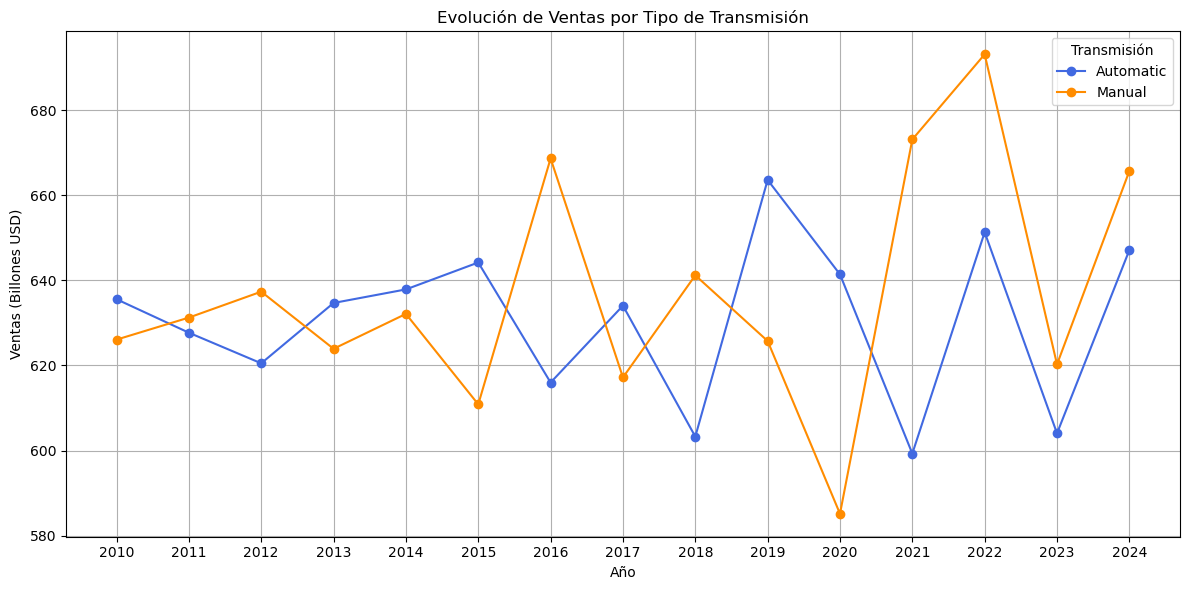

In [139]:
# Convertir los resultados a DataFrame
df9 = pd.DataFrame(resultado9, columns=['Transmission', 'Year', 'Total_Volume_Sales', 'Total_Sales'])

# Escalar a Billones para mejor lectura
df9['Total_Sales_B'] = df9['Total_Sales'] / 1_000_000_000

# Obtener los valores únicos de los tipos de transmisión 
transmissions = df9['Transmission'].unique()
colors = ['royalblue', 'darkorange'] 

plt.figure(figsize=(12, 6))

# Plotear cáda tipo de transmisión
for i, transmission in enumerate(transmissions):
    df_trans = df9[df9['Transmission'] == transmission]
    plt.plot(
        df_trans['Year'],
        df_trans['Total_Sales_B'],
        marker='o',
        color=colors[i],
        label=transmission
    )

# Eti
plt.title("Evolución de Ventas por Tipo de Transmisión")
plt.xlabel("Año")
plt.ylabel("Ventas (Billones USD)")
plt.xticks(df9['Year'].unique())
plt.legend(title='Transmisión')
plt.grid(True)
plt.tight_layout()
plt.show()

## Premiuim vs Gama media

Premium (Modelos de lujo, alta gama o deportivos de élite):

- i8 (híbrido deportivo de alta gama)
- X6 (SUV coupé de gama alta)
- X5 (SUV grande y lujoso)
- M5 (versión deportiva de alto rendimiento del Serie 5)
- M3 (versión deportiva del Serie 3)
- 7 Series (berlina de lujo tope de gama)
- 5 Series (berlina ejecutiva; gama alta en BMW)

No premium (dentro de la marca - Modelos de gama media o entrada):

- i3 (compacto eléctrico urbano)
- X3 (SUV mediano de gama media)
- X1 (SUV compacto de entrada)
- 3 Series (berlina de gama media)

In [118]:
# CONSULTA 10: ¿ Cuál es el rendimiento de modelos Premium vs Gama media?

consulta10 = """
SELECT Category,
       SUM(Sales_Volume) AS Total_Volume_Sales,
       SUM(Total_Sales) AS Total_Sales
FROM (
    SELECT *,
        CASE 
            WHEN Model IN ('i8', 'X6', 'X5', 'M5', 'M3', '7 Series', '5 Series') THEN 'Premium'
            WHEN Model IN ('i3', 'X3', 'X1', '3 Series') THEN 'Gama_media'
            ELSE 'Other'
        END AS Category
    FROM ventas_bmw
)
WHERE Category IN ('Premium', 'Gama_media')
GROUP BY Category;
"""

cursor.execute(consulta10)
resultado10 = cursor.fetchall()

print("Categoría - Unidades Vendidas - Total Ventas en USD")
for category, total_volume_sales, total_sales in resultado10:
    print(f"{category} -- {total_volume_sales} -- {total_sales}")

Categoría - Unidades Vendidas - Total Ventas en USD
Gama_media -- 92566741 -- 6953668032267
Premium -- 160808993 -- 12058574502192


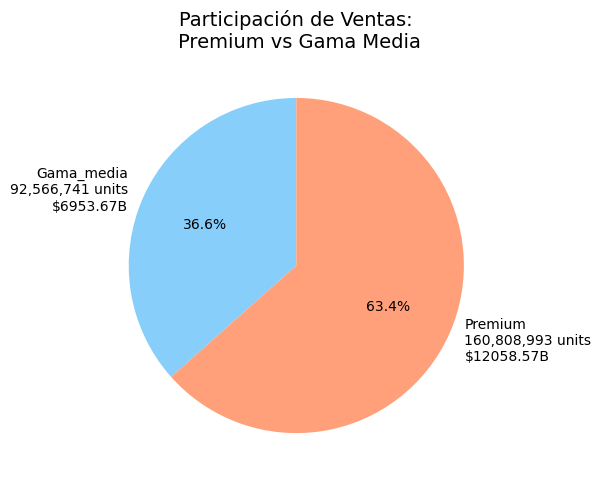

In [124]:
# Convertir los resultados a DataFrame
df10 = pd.DataFrame(resultado10, columns=['Category', 'Total_Volume_Sales', 'Total_Sales'])

# Preparar la etiqutas en unidades USD
labels = []
for i, row in df10.iterrows():
    category = row['Category']
    units = row['Total_Volume_Sales']
    usd = row['Total_Sales'] / 1_000_000_000 
    label = f"{category}\n{units:,} units\n${usd:.2f}B"
    labels.append(label)

sizes = df10['Total_Sales']  

# Colores para cáda categoría
colors = ['lightskyblue', 'lightsalmon']

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors[:len(labels)],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10}
)

plt.title("Participación de Ventas:\n Premium vs Gama Media", fontsize=14)
plt.tight_layout()
plt.show()


In [140]:
cursor.close()
conn.close()